In [7]:
# -*- coding: utf-8 -*-
"""model-vit-enhanced.ipynb

Penerapan peningkatan berdasarkan rekomendasi sebelumnya.
"""

# =========================
# Cell 1: Imports and Setup
# =========================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
from transformers import ViTModel, ViTConfig
import glob
from torch.utils.tensorboard import SummaryWriter
import torch.cuda.amp as amp
import seaborn as sns

In [8]:
# =========================
# Cell 3: Define Device
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')


Device: cuda


In [9]:
# =========================
# Cell 4: Download and Extract Data
# =========================
import gdown
import zipfile

url = "https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182"
output = 'Penyisiha_Hology_Data_Mining.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()
os.remove(output)

Downloading...
From: https://drive.google.com/uc?id=1TbHce2SU-W_Fr2hMjN9E_WhC_1R9M182
To: /content/Penyisiha_Hology_Data_Mining.zip
100%|██████████| 10.2M/10.2M [00:00<00:00, 190MB/s]


In [10]:
# =========================
# Cell 5: Paths and Data Loading
# =========================
train_img_folder = '/content/Penyisihan Hology Data Mining/train'  # Update with the path to your train folder
csv_file = '/content/Penyisihan Hology Data Mining/train.csv'  # Update with the path to your train.csv

# Load train.csv
train_df = pd.read_csv(csv_file)


In [11]:
# =========================
# Cell 6: Data Augmentation and Preprocessing
# =========================
IMG_SIZE = (224, 224)

data_transforms_train = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(degrees=5),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Preprocessing for validation
data_transforms_val = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [12]:
# =========================
# Cell 7: Custom Dataset Class with Improved Image Handling
# =========================
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.valid_indices = self._filter_valid_images()

    def _filter_valid_images(self):
        valid_indices = []
        for idx in range(len(self.dataframe)):
            img_id = self.dataframe.iloc[idx]['id']
            if self.get_image_path(img_id):
                valid_indices.append(idx)
            else:
                print(f"Image {img_id} not found. Skipping.")
        return valid_indices

    def get_image_path(self, img_id):
        extensions = ['.jpg', '.JPG', '.png']
        for ext in extensions:
            path = os.path.join(self.img_dir, f"{img_id}{ext}")
            if os.path.exists(path):
                return path
        return None

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_id = self.dataframe.iloc[actual_idx]['id']
        jenis_label = self.dataframe.iloc[actual_idx]['jenis']
        warna_label = self.dataframe.iloc[actual_idx]['warna']

        img_path = self.get_image_path(img_id)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            image = Image.new('RGB', IMG_SIZE)

        if self.transform:
            image = self.transform(image)

        return image, jenis_label, warna_label

In [13]:
# =========================
# Cell 8: Data Splitting with Stratification
# =========================
# Create a combined label for stratification
train_df['combined'] = train_df['jenis'].astype(str) + "_" + train_df['warna'].astype(str)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(train_df, train_df['combined']):
    train_df_strat, val_df_strat = train_df.iloc[train_index], train_df.iloc[val_index]


In [14]:
# =========================
# Cell 9: Compute Class Weights
# =========================
def compute_class_weights(dataframe, column):
    class_counts = dataframe[column].value_counts().sort_index().values
    class_weights = 1. / class_counts
    return class_weights

# Get weights for 'jenis' and 'warna'
jenis_weights = compute_class_weights(train_df_strat, 'jenis')
warna_weights = compute_class_weights(train_df_strat, 'warna')

# Compute sample weights for each row in the dataframe
sample_weights = []
for idx in range(len(train_df_strat)):
    jenis_label = train_df_strat.iloc[idx]['jenis']
    warna_label = train_df_strat.iloc[idx]['warna']
    sample_weight = jenis_weights[jenis_label] + warna_weights[warna_label]
    sample_weights.append(sample_weight)

# Create a sampler for balanced dataset
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [15]:

# =========================
# Cell 10: Dataset and Dataloader with Optimizations
# =========================
# Create dataset
train_dataset = CustomImageDataset(train_df_strat, train_img_folder, transform=data_transforms_train)
val_dataset = CustomImageDataset(val_df_strat, train_img_folder, transform=data_transforms_val)

# Create DataLoaders with optimized settings
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
# =========================
# Cell 11: Model Setup with Separate Classifiers and Dropout
# =========================
# Load Vision Transformer (ViT) pretrained on ImageNet
vit_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Freeze ViT layers for fine-tuning
for param in vit_model.parameters():
    param.requires_grad = False

# Custom model with separate classifiers
class CustomViTClassifier(nn.Module):
    def __init__(self, vit_model, vit_config, num_classes_jenis, num_classes_warna):
        super(CustomViTClassifier, self).__init__()
        self.vit = vit_model
        self.classifier_jenis = nn.Sequential(
            nn.Linear(vit_config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes_jenis)
        )
        self.classifier_warna = nn.Sequential(
            nn.Linear(vit_config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes_warna)
        )

    def forward(self, x):
        outputs = self.vit(pixel_values=x)
        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        logits_jenis = self.classifier_jenis(pooled_output)
        logits_warna = self.classifier_warna(pooled_output)
        return logits_jenis, logits_warna

# Define number of classes
num_classes_jenis = 2
num_classes_warna = 5

# Initialize model
model = CustomViTClassifier(vit_model, vit_config, num_classes_jenis, num_classes_warna)
model = model.to(device)



In [17]:
# =========================
# Cell 12: Define Loss, Optimizer, and Scheduler
# =========================
criterion_jenis = nn.CrossEntropyLoss()
criterion_warna = nn.CrossEntropyLoss()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Scheduler that reduces LR when a metric has stopped improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Initialize mixed precision scaler
scaler = amp.GradScaler()

# Initialize TensorBoard writer
writer = SummaryWriter()


<ipython-input-17-c20fb0d69987>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [18]:
# =========================
# Cell 13: Model Training and Evaluation Functions
# =========================
def evaluate_model(model, val_loader):
    model.eval()
    all_preds_jenis = []
    all_preds_warna = []
    all_labels_jenis = []
    all_labels_warna = []

    with torch.no_grad():
        for images, jenis_labels, warna_labels in val_loader:
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)

            logits_jenis, logits_warna = model(images)
            preds_jenis = torch.argmax(logits_jenis, dim=1).cpu().numpy()
            preds_warna = torch.argmax(logits_warna, dim=1).cpu().numpy()

            all_preds_jenis.extend(preds_jenis)
            all_preds_warna.extend(preds_warna)
            all_labels_jenis.extend(jenis_labels.cpu().numpy())
            all_labels_warna.extend(warna_labels.cpu().numpy())

    accuracy_jenis = accuracy_score(all_labels_jenis, all_preds_jenis)
    accuracy_warna = accuracy_score(all_labels_warna, all_preds_warna)

    precision_jenis = precision_score(all_labels_jenis, all_preds_jenis, average='macro')
    precision_warna = precision_score(all_labels_warna, all_preds_warna, average='macro')

    recall_jenis = recall_score(all_labels_jenis, all_preds_jenis, average='macro')
    recall_warna = recall_score(all_labels_warna, all_preds_warna, average='macro')

    f1_jenis = f1_score(all_labels_jenis, all_preds_jenis, average='macro')
    f1_warna = f1_score(all_labels_warna, all_preds_warna, average='macro')

    hamming = hamming_loss(np.hstack([all_labels_jenis, all_labels_warna]), np.hstack([all_preds_jenis, all_preds_warna]))

    jaccard_jenis = jaccard_score(all_labels_jenis, all_preds_jenis, average='macro')
    jaccard_warna = jaccard_score(all_labels_warna, all_preds_warna, average='macro')

    return {
        'accuracy_jenis': accuracy_jenis,
        'accuracy_warna': accuracy_warna,
        'precision_jenis': precision_jenis,
        'precision_warna': precision_warna,
        'recall_jenis': recall_jenis,
        'recall_warna': recall_warna,
        'f1_jenis': f1_jenis,
        'f1_warna': f1_warna,
        'hamming_loss': hamming,
        'jaccard_jenis': jaccard_jenis,
        'jaccard_warna': jaccard_warna
    }

def train_model(model, train_loader, val_loader, criterion_jenis, criterion_warna, optimizer, scheduler, scaler, writer, num_epochs=50):
    train_losses = []
    val_losses = []
    metrics_list = []
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, jenis_labels, warna_labels in train_loader:
            images = images.to(device)
            jenis_labels = jenis_labels.to(device)
            warna_labels = warna_labels.to(device)

            optimizer.zero_grad()

            with amp.autocast():
                logits_jenis, logits_warna = model(images)
                loss_jenis = criterion_jenis(logits_jenis, jenis_labels)
                loss_warna = criterion_warna(logits_warna, warna_labels)
                loss = loss_jenis + loss_warna

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, jenis_labels, warna_labels in val_loader:
                images = images.to(device)
                jenis_labels = jenis_labels.to(device)
                warna_labels = warna_labels.to(device)

                logits_jenis, logits_warna = model(images)
                loss_jenis = criterion_jenis(logits_jenis, jenis_labels)
                loss_warna = criterion_warna(logits_warna, warna_labels)
                loss = loss_jenis + loss_warna

                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Evaluate metrics
        metrics = evaluate_model(model, val_loader)
        metrics_list.append(metrics)

        # Logging to TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/Jenis', metrics['accuracy_jenis'], epoch)
        writer.add_scalar('Accuracy/Warna', metrics['accuracy_warna'], epoch)
        writer.add_scalar('F1/Jenis', metrics['f1_jenis'], epoch)
        writer.add_scalar('F1/Warna', metrics['f1_warna'], epoch)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()
            torch.save(best_model_wts, 'best_vit_multitask_model.pth')
            print(f"New best model found at epoch {epoch+1}, saving the model...")

        # Step the scheduler
        scheduler.step(val_loss)

    writer.close()

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print("Best model loaded.")
    else:
        print("No improvement during training.")

    return train_losses, val_losses, metrics_list

In [19]:
# =========================
# Cell 14: Plotting Functions
# =========================
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_metrics(metrics_list):
    epochs = range(1, len(metrics_list)+1)
    accuracy_jenis = [m['accuracy_jenis'] for m in metrics_list]
    accuracy_warna = [m['accuracy_warna'] for m in metrics_list]
    f1_jenis = [m['f1_jenis'] for m in metrics_list]
    f1_warna = [m['f1_warna'] for m in metrics_list]

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, accuracy_jenis, label='Jenis Accuracy')
    plt.plot(epochs, accuracy_warna, label='Warna Accuracy')
    plt.plot(epochs, f1_jenis, label='Jenis F1 Score')
    plt.plot(epochs, f1_warna, label='Warna F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Accuracy and F1 Score for Jenis and Warna')
    plt.legend()
    plt.show()

def plot_confusion_matrix_cm(true_labels, pred_labels, label_names, title):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f'Confusion Matrix for {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


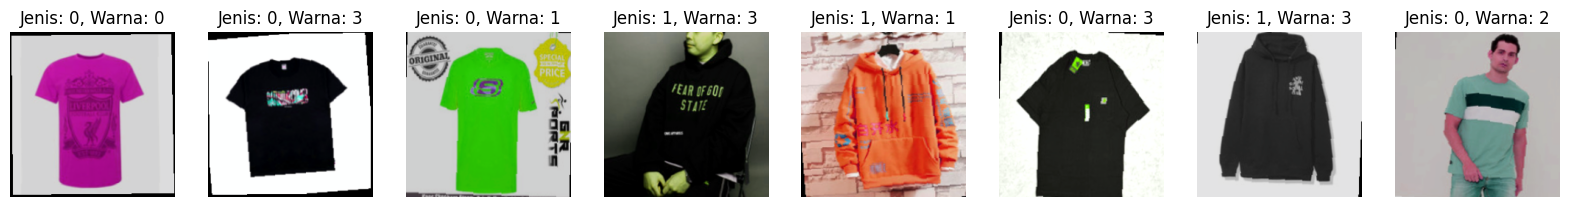

In [20]:
# =========================
# Cell 15: Visualize Augmented Images
# =========================
def visualize_augmented_images(loader, num_images=8):
    batch = next(iter(loader))
    images, jenis_labels, warna_labels = batch

    plt.figure(figsize=(20, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Jenis: {jenis_labels[i]}, Warna: {warna_labels[i]}')
        plt.axis('off')
    plt.show()

# Call this function before the training loop to visualize the augmented images
visualize_augmented_images(train_loader)


In [21]:
# =========================
# Cell 16: Train the Model
# =========================
train_losses, val_losses, metrics_list = train_model(
    model, train_loader, val_loader,
    criterion_jenis, criterion_warna,
    optimizer, scheduler, scaler, writer,
    num_epochs=50
)



<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Train Loss: 2.2413, Val Loss: 2.1466
New best model found at epoch 1, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [2/50], Train Loss: 2.1042, Val Loss: 2.0006
New best model found at epoch 2, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [3/50], Train Loss: 1.9704, Val Loss: 1.8498
New best model found at epoch 3, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [4/50], Train Loss: 1.8300, Val Loss: 1.7109
New best model found at epoch 4, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [5/50], Train Loss: 1.7071, Val Loss: 1.5907
New best model found at epoch 5, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [6/50], Train Loss: 1.5648, Val Loss: 1.4817
New best model found at epoch 6, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [7/50], Train Loss: 1.4739, Val Loss: 1.3847
New best model found at epoch 7, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [8/50], Train Loss: 1.4445, Val Loss: 1.3048
New best model found at epoch 8, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [9/50], Train Loss: 1.3204, Val Loss: 1.2240
New best model found at epoch 9, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [10/50], Train Loss: 1.2862, Val Loss: 1.1499
New best model found at epoch 10, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [11/50], Train Loss: 1.2308, Val Loss: 1.0941
New best model found at epoch 11, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [12/50], Train Loss: 1.2036, Val Loss: 1.0522
New best model found at epoch 12, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [13/50], Train Loss: 1.1546, Val Loss: 0.9915
New best model found at epoch 13, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [14/50], Train Loss: 1.0970, Val Loss: 0.9432
New best model found at epoch 14, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [15/50], Train Loss: 1.0763, Val Loss: 0.9076
New best model found at epoch 15, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [16/50], Train Loss: 0.9970, Val Loss: 0.8755
New best model found at epoch 16, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [17/50], Train Loss: 0.9553, Val Loss: 0.8373
New best model found at epoch 17, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [18/50], Train Loss: 0.9194, Val Loss: 0.8008
New best model found at epoch 18, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [19/50], Train Loss: 0.9407, Val Loss: 0.7829
New best model found at epoch 19, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [20/50], Train Loss: 0.8864, Val Loss: 0.7825
New best model found at epoch 20, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [21/50], Train Loss: 0.8525, Val Loss: 0.7470
New best model found at epoch 21, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [22/50], Train Loss: 0.8363, Val Loss: 0.7275
New best model found at epoch 22, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [23/50], Train Loss: 0.8270, Val Loss: 0.6992
New best model found at epoch 23, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [24/50], Train Loss: 0.8020, Val Loss: 0.6875
New best model found at epoch 24, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [25/50], Train Loss: 0.7992, Val Loss: 0.6800
New best model found at epoch 25, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [26/50], Train Loss: 0.7867, Val Loss: 0.6610
New best model found at epoch 26, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [27/50], Train Loss: 0.7851, Val Loss: 0.6494
New best model found at epoch 27, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [28/50], Train Loss: 0.7594, Val Loss: 0.6389
New best model found at epoch 28, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [29/50], Train Loss: 0.7145, Val Loss: 0.6182
New best model found at epoch 29, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [30/50], Train Loss: 0.6953, Val Loss: 0.6073
New best model found at epoch 30, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [31/50], Train Loss: 0.7809, Val Loss: 0.6085


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [32/50], Train Loss: 0.7061, Val Loss: 0.6050
New best model found at epoch 32, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [33/50], Train Loss: 0.6918, Val Loss: 0.5873
New best model found at epoch 33, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [34/50], Train Loss: 0.6874, Val Loss: 0.5826
New best model found at epoch 34, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [35/50], Train Loss: 0.6484, Val Loss: 0.5628
New best model found at epoch 35, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [36/50], Train Loss: 0.6728, Val Loss: 0.5548
New best model found at epoch 36, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [37/50], Train Loss: 0.6703, Val Loss: 0.5485
New best model found at epoch 37, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [38/50], Train Loss: 0.6233, Val Loss: 0.5462
New best model found at epoch 38, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [39/50], Train Loss: 0.6902, Val Loss: 0.5349
New best model found at epoch 39, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [40/50], Train Loss: 0.6294, Val Loss: 0.5276
New best model found at epoch 40, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [41/50], Train Loss: 0.6237, Val Loss: 0.5193
New best model found at epoch 41, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [42/50], Train Loss: 0.6298, Val Loss: 0.5259


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [43/50], Train Loss: 0.6410, Val Loss: 0.5281


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [44/50], Train Loss: 0.6478, Val Loss: 0.5322


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [45/50], Train Loss: 0.6464, Val Loss: 0.5299


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [46/50], Train Loss: 0.5918, Val Loss: 0.5162
New best model found at epoch 46, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [47/50], Train Loss: 0.6080, Val Loss: 0.5111
New best model found at epoch 47, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [48/50], Train Loss: 0.5301, Val Loss: 0.5077
New best model found at epoch 48, saving the model...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [49/50], Train Loss: 0.6151, Val Loss: 0.5129


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-18-be31c89d131e>:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [50/50], Train Loss: 0.5877, Val Loss: 0.5228
Best model loaded.


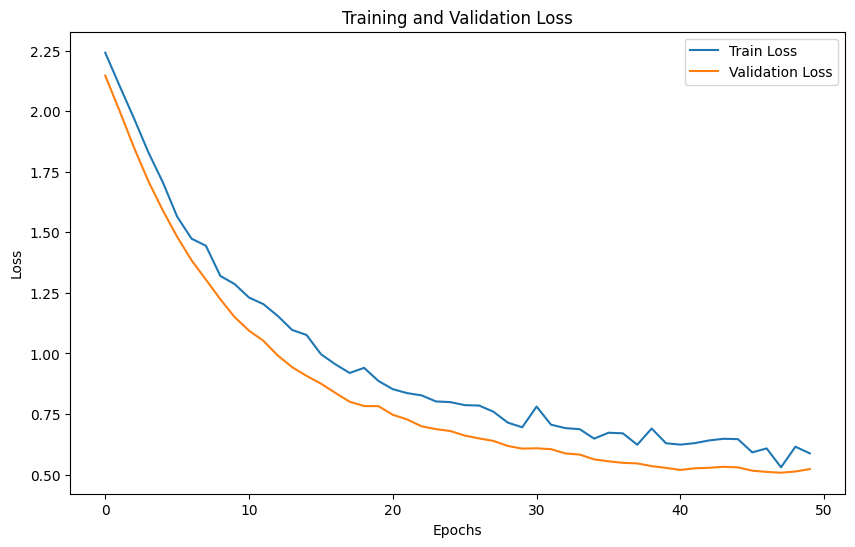

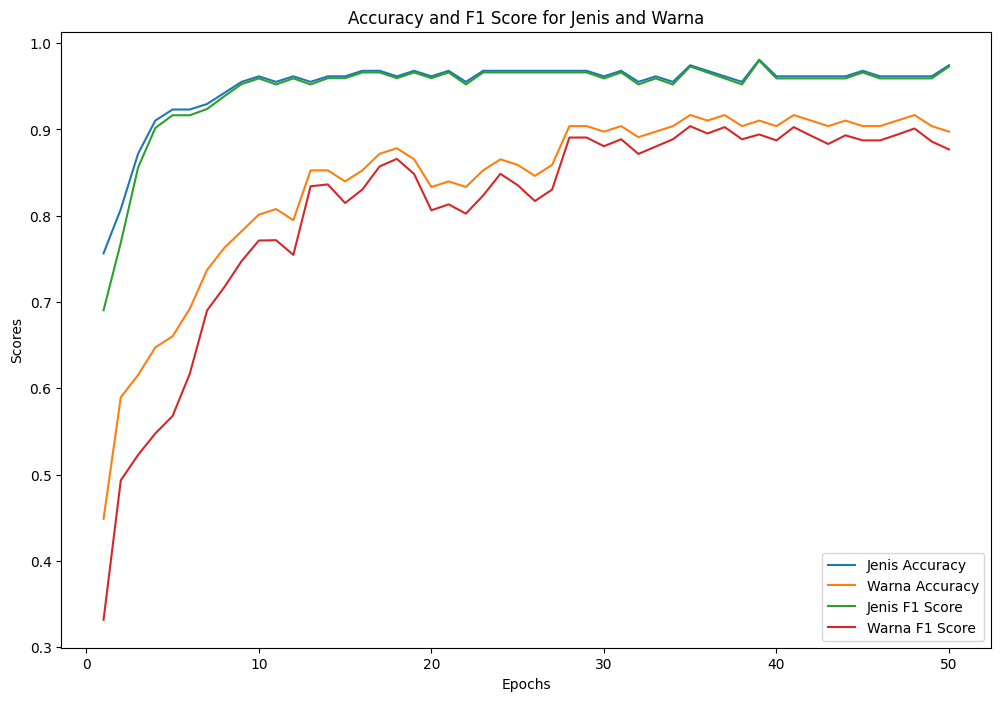

In [22]:
# =========================
# Cell 17: Plot the Results
# =========================
plot_losses(train_losses, val_losses)
plot_metrics(metrics_list)


<ipython-input-23-e52d5c104c28>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
/usr/local/lib/python3.10/dist-packages/torch/

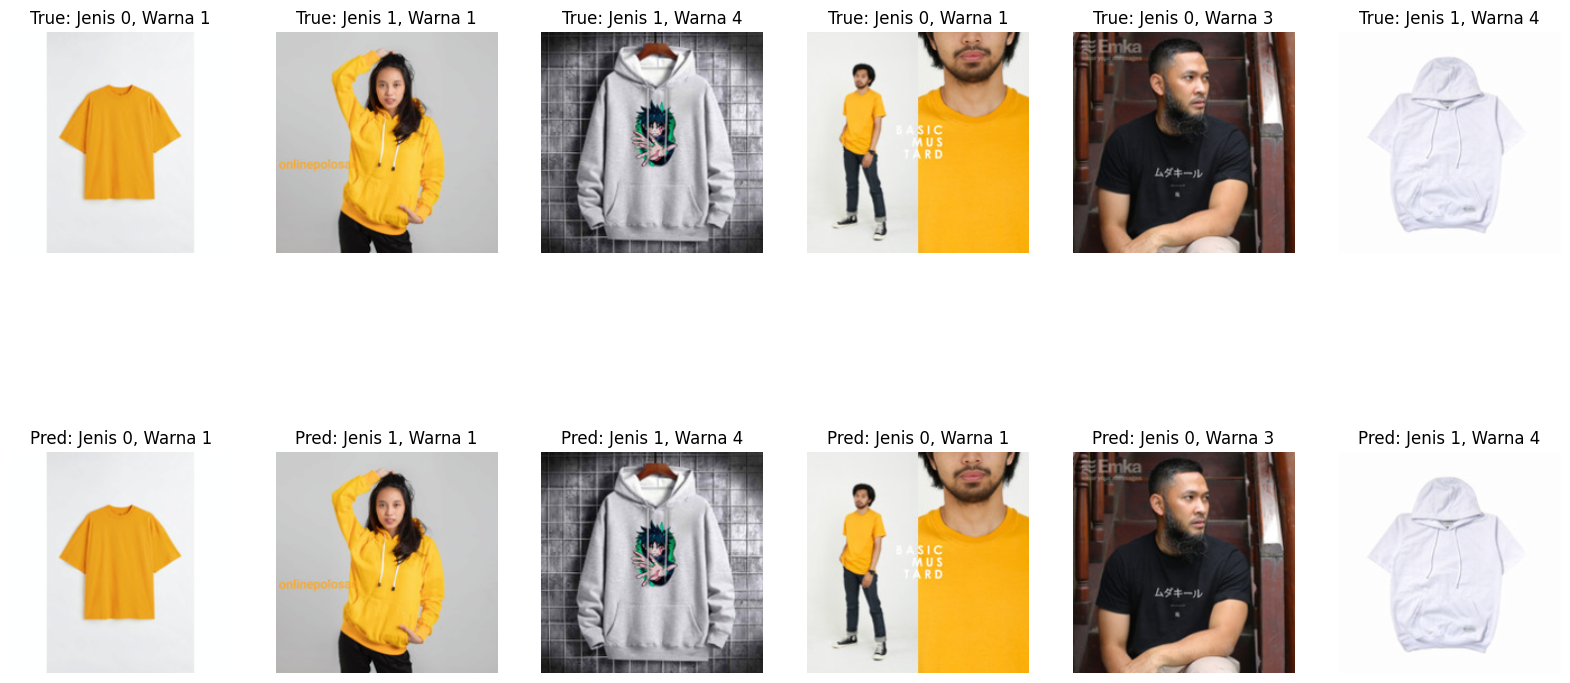

In [23]:
# =========================
# Cell 18: Load Fine-tuned Model and Visualize Predictions
# =========================
def load_fine_tuned_model(model_path, model):
    # Load the fine-tuned model weights from the .pth file
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

def visualize_fine_tuned_predictions(model, loader, num_images=6):
    model.eval()

    # Get a random batch of images from the loader
    random_batch = random.randint(0, len(loader)-1)
    for i, batch in enumerate(loader):
        if i == random_batch:
            images, true_jenis_labels, true_warna_labels = batch
            break

    images = images.to(device)

    with torch.no_grad():
        logits_jenis, logits_warna = model(images)

    preds_jenis = torch.argmax(logits_jenis, dim=1).cpu().numpy()
    preds_warna = torch.argmax(logits_warna, dim=1).cpu().numpy()

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(2, num_images, i+1)
        plt.imshow(img)
        plt.title(f'True: Jenis {true_jenis_labels[i]}, Warna {true_warna_labels[i]}')
        plt.axis('off')

        plt.subplot(2, num_images, i+1+num_images)
        plt.imshow(img)
        plt.title(f'Pred: Jenis {preds_jenis[i]}, Warna {preds_warna[i]}')
        plt.axis('off')
    plt.show()

# Load the fine-tuned model from the saved .pth file
fine_tuned_model_path = 'best_vit_multitask_model.pth'
model = load_fine_tuned_model(fine_tuned_model_path, model)

# Visualize predictions using the fine-tuned model
visualize_fine_tuned_predictions(model, val_loader)

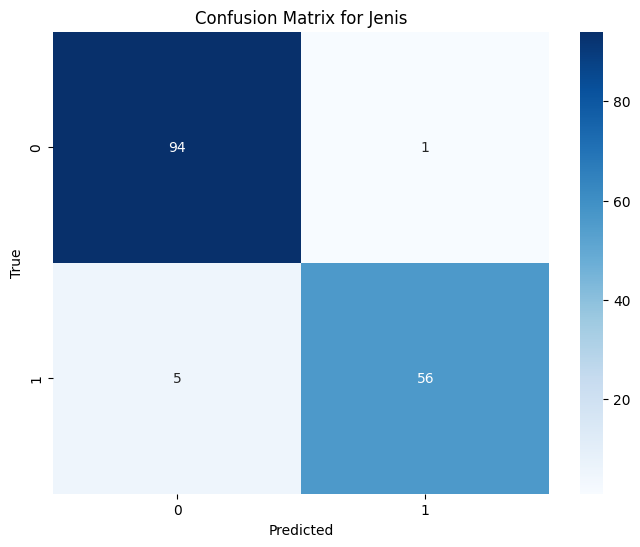

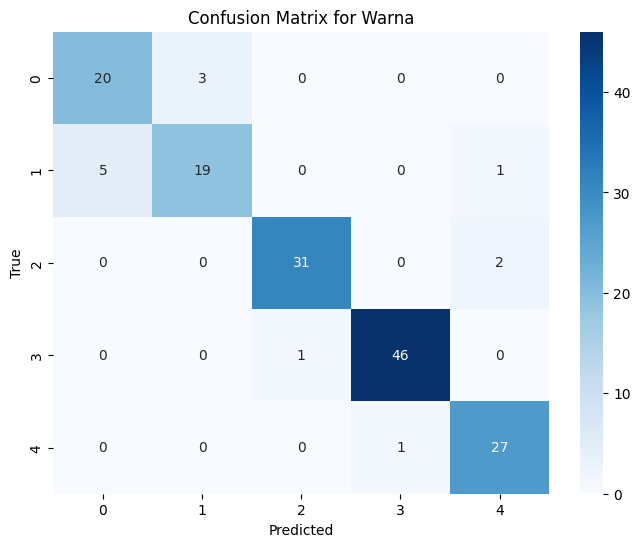

In [24]:
# =========================
# Cell 19: Confusion Matrix Visualization for 'Jenis' and 'Warna' Labels
# =========================
def evaluate_and_plot_confusion_matrix(model, loader, label_names_jenis, label_names_warna):
    model.eval()
    true_jenis_labels_list = []
    true_warna_labels_list = []
    preds_jenis_list = []
    preds_warna_list = []

    with torch.no_grad():
        for images, true_jenis_labels, true_warna_labels in loader:
            images = images.to(device)
            logits_jenis, logits_warna = model(images)

            preds_jenis = torch.argmax(logits_jenis, dim=1).cpu().numpy()
            preds_warna = torch.argmax(logits_warna, dim=1).cpu().numpy()

            true_jenis_labels_list.extend(true_jenis_labels.numpy())
            true_warna_labels_list.extend(true_warna_labels.numpy())
            preds_jenis_list.extend(preds_jenis)
            preds_warna_list.extend(preds_warna)

    # Plot confusion matrix for 'jenis'
    plot_confusion_matrix_cm(true_jenis_labels_list, preds_jenis_list, label_names_jenis, 'Jenis')

    # Plot confusion matrix for 'warna'
    plot_confusion_matrix_cm(true_warna_labels_list, preds_warna_list, label_names_warna, 'Warna')

# Define label names if available, else use numeric labels
label_names_jenis = sorted(train_df['jenis'].unique())
label_names_warna = sorted(train_df['warna'].unique())

# Evaluate and plot confusion matrix for fine-tuned model
evaluate_and_plot_confusion_matrix(model, val_loader, label_names_jenis, label_names_warna)

In [25]:
# =========================
# Cell 20: Inference Code for ViT Model
# =========================
# Load the saved model for inference
model.load_state_dict(torch.load('best_vit_multitask_model.pth'))
model.eval()  # Set to evaluation mode

# Folder for test images
test_img_folder = '/content/Penyisihan Hology Data Mining/test'

# Image transformations
data_transforms_inference = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Load test images from folder for a specific range of image IDs
def load_test_images_from_folder(folder, start_id=778, end_id=1111):
    images = []
    img_ids = []

    for img_id in range(start_id, end_id + 1):
        # Use glob to find the image with any of the allowed extensions
        img_path = None
        for ext in ['.jpg', '.JPG', '.png']:
            found = glob.glob(os.path.join(folder, f"{img_id}{ext}"))
            if found:
                img_path = found[0]
                break

        if not img_path:
            print(f"Image with ID {img_id} not found in jpg or png format.")
            continue  # Skip this ID if no image is found

        try:
            image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
            image = data_transforms_inference(image)  # Apply transformations
            images.append(image)
            img_ids.append(img_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            continue  # Skip the image if there's an error

    if not images:
        raise ValueError("No images were loaded. Please check the test image folder.")

    return torch.stack(images), img_ids  # Return tensor and corresponding image IDs

# Example usage
test_images, test_img_ids = load_test_images_from_folder(test_img_folder, start_id=778, end_id=1111)
test_images = test_images.to(device)

# Inference with batch processing
def perform_inference(model, test_images, batch_size=32):
    model.eval()
    jenis_predictions = []
    warna_predictions = []
    with torch.no_grad():
        for i in range(0, len(test_images), batch_size):
            batch = test_images[i:i+batch_size]
            logits_jenis, logits_warna = model(batch)
            preds_jenis = torch.argmax(logits_jenis, dim=1).cpu().numpy()
            preds_warna = torch.argmax(logits_warna, dim=1).cpu().numpy()
            jenis_predictions.extend(preds_jenis)
            warna_predictions.extend(preds_warna)
    return jenis_predictions, warna_predictions

# Get predictions
jenis_predictions, warna_predictions = perform_inference(model, test_images)

# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'id': test_img_ids,  # Use the extracted IDs from filenames
    'jenis': jenis_predictions,
    'warna': warna_predictions
})

# Save the results to CSV
result_df.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'.")

<ipython-input-25-80baa63887bd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_multitask_model.pth'))


Predictions saved to 'test_predictions.csv'.
